In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

"""
Loading the data
"""
pd.options.display.max_colwidth = 1500
pd.options.display.max_rows = 1000

df = pd.read_csv(r'books_and_genres.csv')

# drop the extra index column
df = df.drop(columns=df.columns[0])

df.head()

,title,text,genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Distributed Proofreaders\n\n\n\n\n SENECA\n\n APOCOLOCYNTOSIS\n\n WITH AN ENGLISH TRANSLATION BY\n\n W.H.D. ROUSE, M.A. LITT. D.\n\n MCMXX\n\n\n\n\n\nINTRODUCTION\n\nThis piece is ascribed to Seneca by ancient tradition; it is impossible\nto prove that it is his, and impossible to prove that it is not. The\nmatter will probably continue to be decided by every one according to his\nview of Seneca's character and abilities: in the matters of style and of\nsentiment much may be said on both sides. Dion Cassius (lx, 35) says that\nSeneca composed an [Greek: apokolokuntosis] or Pumpkinification of\nClaudius after his death, the title being a parody of the usual\n[Greek: apotheosis]; but this title is not given in the MSS. of the Ludus\nde Morte Claudii, nor is there anything in the piece which suits the title\nvery well.\n\nAs a literary form, the piece belongs to the class called\n_Satura Menippea_, a satiric medley in prose and verse.\n\nThis text is that of Buecheler, with a few trifling changes, which are\nindicated in the notes. We have been courteously allowed by Messrs\nWeidmann to use this text. I have to acknowledge the help of Mr Ball's\nnotes, from which I have taken a few references; but my translation was\nmade many years ago.\n\nW.H.D. ROUSE.\n\n\n\n\n\nBIBLIOGRAPHY\n\n_Editio Princeps:_ Lucii Annaei Senecae in morte\n Claudii Caesaris Lud...","{'21st-century', 'history', 'roman', 'classics', 'religion', 'novels', 'philosophy', 'fiction', 'literature', 'short-stories', 'politics', 'non-fiction', 'read-for-school', 'poetry', 'historical', 'humor'}"
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distributed Proofreaders\n\n\n\n\nTHE HOUSE ON THE BORDERLAND\n\nWilliam Hope Hodgson\n\n\n_From the Manuscript discovered in 1877 by Messrs. Tonnison and\nBerreggnog in the Ruins that lie to the South of the Village of\nKraighten, in the West of Ireland. Set out here, with Notes_.\n\n\nTO MY FATHER\n_(Whose feet tread the lost aeons)_\n\nOpen the door,\n And listen!\nOnly the wind's muffled roar,\n And the glisten\nOf tears 'round the moon.\n And, in fancy, the tread\nOf vanishing shoon--\n Out in the night with the Dead.\n\n""Hush! And hark\n To the sorrowful cry\nOf the wind in the dark.\n Hush and hark, without murmur or sigh,\n To shoon that tread the lost aeons:\n To the sound that bids you to die.\nHush and hark! Hush and Hark!""\n _Shoon of the Dead_\n\n\n\n\nAUTHOR'S INTRODUCTION TO THE MANUSCRIPT\n\nMany are the hours in which I have pondered upon the story that is set\nforth in the following pages. I trust that my instincts are not awry\nwhen they prompt me to leave the account, in simplicity, as it was\nhanded to me.\n\nAnd the MS. itself--You must picture me, when first it was given into my\ncare, turning it over, curiously, and making a swift, jerky examination.\nA small book it is; but thick, and all, save the last few pages, filled\nwith a quaint but legible handwriting, and writ very close. I have the\nqueer, faint, pit-water smell of it in my nostrils now as I write, and\nmy f...","{'horror', 'mystery', 'classics', 'science-fiction', 'fantasy', 'novels', 'literature', 'fiction', 'paranormal', '20th-century', 'adult', 'speculative-fiction', 'supernatural', 'dark'}"
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschner\nand the Online Distributed Proofreading Team.\n\n\n\n\nTHE WARRIORS\n\nBY ANNA ROBERTSON BROWN LINDSAY PH.D.\n\nAUTHOR OF\n\nWHAT IS WORTH WHILE?\nCULTURE AND REFORM\nTHE VICTORY OF OUR FAITH\n\n\n\n\nPREFACE\n\nThis work was begun nearly five years ago. Since then, the whole face of\nAmerican history has changed. We have had the Spanish-American War, and\nthe opening-up of our new possessions. In this period of time Gladstone,\nLi Hung Chang, and Queen Victoria have died; there has also occurred the\nassassination of the Empress of Austria and of President McKinley. There\nhas bee

In [3]:
"""
Basic formatting
"""
# stringify all text
df['text'] = df['text'].map(str)
df = df.replace({r'\r\n|\r|\n': ' '}, regex=True)

df.head(5)

,title,text,genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Distributed Proofreaders SENECA APOCOLOCYNTOSIS WITH AN ENGLISH TRANSLATION BY W.H.D. ROUSE, M.A. LITT. D. MCMXX INTRODUCTION This piece is ascribed to Seneca by ancient tradition; it is impossible to prove that it is his, and impossible to prove that it is not. The matter will probably continue to be decided by every one according to his view of Seneca's character and abilities: in the matters of style and of sentiment much may be said on both sides. Dion Cassius (lx, 35) says that Seneca composed an [Greek: apokolokuntosis] or Pumpkinification of Claudius after his death, the title being a parody of the usual [Greek: apotheosis]; but this title is not given in the MSS. of the Ludus de Morte Claudii, nor is there anything in the piece which suits the title very well. As a literary form, the piece belongs to the class called _Satura Menippea_, a satiric medley in prose and verse. This text is that of Buecheler, with a few trifling changes, which are indicated in the notes. We have been courteously allowed by Messrs Weidmann to use this text. I have to acknowledge the help of Mr Ball's notes, from which I have taken a few references; but my translation was made many years ago. W.H.D. ROUSE. BIBLIOGRAPHY _Editio Princeps:_ Lucii Annaei Senecae in morte Claudii Caesaris Ludus nuper repertus: Rome, 1513. _Latest critical...","{'21st-century', 'history', 'roman', 'classics', 'religion', 'novels', 'philosophy', 'fiction', 'literature', 'short-stories', 'politics', 'non-fiction', 'read-for-school', 'poetry', 'historical', 'humor'}"
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distributed Proofreaders THE HOUSE ON THE BORDERLAND William Hope Hodgson _From the Manuscript discovered in 1877 by Messrs. Tonnison and Berreggnog in the Ruins that lie to the South of the Village of Kraighten, in the West of Ireland. Set out here, with Notes_. TO MY FATHER _(Whose feet tread the lost aeons)_ Open the door, And listen! Only the wind's muffled roar, And the glisten Of tears 'round the moon. And, in fancy, the tread Of vanishing shoon-- Out in the night with the Dead. ""Hush! And hark To the sorrowful cry Of the wind in the dark. Hush and hark, without murmur or sigh, To shoon that tread the lost aeons: To the sound that bids you to die. Hush and hark! Hush and Hark!"" _Shoon of the Dead_ AUTHOR'S INTRODUCTION TO THE MANUSCRIPT Many are the hours in which I have pondered upon the story that is set forth in the following pages. I trust that my instincts are not awry when they prompt me to leave the account, in simplicity, as it was handed to me. And the MS. itself--You must picture me, when first it was given into my care, turning it over, curiously, and making a swift, jerky examination. A small book it is; but thick, and all, save the last few pages, filled with a quaint but legible handwriting, and writ very close. I have the queer, faint, pit-water smell of it in my nostrils now as I write, and my fingers have subconscious memories of the soft, ""clo...","{'horror', 'mystery', 'classics', 'science-fiction', 'fantasy', 'novels', 'literature', 'fiction', 'paranormal', '20th-century', 'adult', 'speculative-fiction', 'supernatural', 'dark'}"
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschner and the Online Distributed Proofreading Team. THE WARRIORS BY ANNA ROBERTSON BROWN LINDSAY PH.D. AUTHOR OF WHAT IS WORTH WHILE? CULTURE AND REFORM THE VICTORY OF OUR FAITH PREFACE This work was begun nearly five years ago. Since then, the whole face of American history has changed. We have had the Spanish-American War, and the opening-up of our new possessions. In this period of time Gladstone, Li Hung Chang, and Queen Victoria have died; there has also occurred the assassination of the Empress of Austria and of President McKinley. There has been the Chinese persecution, the destruction of Galveston by storm and of Martinique by volcanic 

In [4]:
"""
Methods that will be used in the next block to try to source a published date
"""
import re
import roman;
from roman import InvalidRomanNumeralError

# regex for finding Gregorian or Roman publish dates
rn_year_regex = r'\b(.[M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))]{3,})\b'
modern_year_regex = r'(\b\d{4}\b)'
valid_year_regex = f'{modern_year_regex}|{rn_year_regex}'

# methods for finding above regex matches in text
find_year = re.compile('('+rn_year_regex+'|'+modern_year_regex+')');
find_modern_year = re.compile('('+modern_year_regex+')')

def is_right_era(int_date):
    return 1000 < int_date < 1922

def get_valid_date(date):
    try:
        int_date = int(date)
    except (ValueError, TypeError):
        return 0
    
    if is_right_era(int_date):
        return int_date
    
    return 0

def convert_date(date):
    if date == 'no date':
        return 0
    
    valid_date = get_valid_date(date)
    if valid_date:
        return valid_date
    
    try:
        number = roman.fromRoman(date.strip())
    except (InvalidRomanNumeralError, TypeError, AttributeError) as e:
        return 0
    
    valid_date = get_valid_date(number)
    return int(number)




In [5]:
"""
Try to source a published date from the intro text of each book and write to new "year" column
"""

# try to find either a Roman or Gregorian year within the text of each book, and insert into the "year" column
df['year'] = df['text'].map(lambda t: (find_year.search( t[0:1000]) or ["no date"])[0])

# no date before
print(len(df.loc[df['year'] == 'no date']))
df['year'] = df['year'].map(convert_date)

# no date after :(
print(len(df.loc[df['year'] == 0]))


3721
4797


In [6]:
"""
Methods that will be used in the next block to try to source published date from Google Books
"""

import requests
import time

# ADD YOUR GOOGLE BOOKS API CLIENT SECRET HERE IF YOU WOULD LIKE TO RUN THIS PORTION
secret = ''

def is_valid_date(date):
    try:
        int_date = int(date)
    except ValueError:
        return False
    return is_right_era(int_date)

def find_publication_year_from_item(item):
    published_date = item['volumeInfo'].get('publishedDate', '')
    if published_date and is_valid_date(published_date):
        return published_date
    
    # if there is no valid publishedDate, search in the description text of the response
    description = item['volumeInfo'].get('description', '')
    possible_dates = [date[0] for date in find_modern_year.findall(description) if is_valid_date(date[0])]
    if possible_dates:
        return min(possible_dates)

# check the Google Books API by a book's title in order to get the publication year
def get_publication_year(title):
    if not secret:
        print('Please assign value to "secret" variable above with your Google Books API key')
        return
    
    # avoid per-minute rate limiting
    time.sleep(0.05)
    url = f'https://www.googleapis.com/books/v1/volumes?q={title}&key={secret}'
    response = requests.get(url)
    
    try:
        items = response.json()['items']
    except KeyError as e:
        print('No matches found for ', title, response.json())
        return 0
    
    possible_years = [found for item in items if (found := find_publication_year_from_item(item)) is not None]
    if possible_years:
        year = min(possible_years)
        print(f'{title}: {year}')
        return year
    
    print('could not find year for title ', title)
    return 0


In [24]:
"""
Loop over the rows missing a publication year and run the above methods to attempt to fill it.
This needs to be done in batches because of rate limiting.

CSV with saved results imported in file in leui of live fetching. See commented out block below
if you would like to test it (you will need a Google Book API client key)
"""

# If you would like to test this out, uncomment the block below and use your own secret key in the block above
# dfcopy = df.copy()[0:100]
# dfcopy.loc[dfcopy['year'] == 0, 'year'] = dfcopy.loc[dfcopy['year'] == 0]['title'].apply(get_publication_year)

# read from the already compiled set instead of fetching live from Google Books API
dfFull = pd.read_csv('fullset.csv')

# Extra formatting!
# Force the year into an int and the text into a string
dfFull.year = dfFull.year.astype('int')
dfFull['text'] = dfFull['text'].astype(str)

# Drop the "genres" column as we will not use it
dfFull = dfFull.drop("genres", axis=1)

dfFull.head(3)

,title,text,year
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Distributed Proofreaders SENECA APOCOLOCYNTOSIS WITH AN ENGLISH TRANSLATION BY W.H.D. ROUSE, M.A. LITT. D. MCMXX INTRODUCTION This piece is ascribed to Seneca by ancient tradition; it is impossible to prove that it is his, and impossible to prove that it is not. The matter will probably continue to be decided by every one according to his view of Seneca's character and abilities: in the matters of style and of sentiment much may be said on both sides. Dion Cassius (lx, 35) says that Seneca composed an [Greek: apokolokuntosis] or Pumpkinification of Claudius after his death, the title being a parody of the usual [Greek: apotheosis]; but this title is not given in the MSS. of the Ludus de Morte Claudii, nor is there anything in the piece which suits the title very well. As a literary form, the piece belongs to the class called _Satura Menippea_, a satiric medley in prose and verse. This text is that of Buecheler, with a few trifling changes, which are indicated in the notes. We have been courteously allowed by Messrs Weidmann to use this text. I have to acknowledge the help of Mr Ball's notes, from which I have taken a few references; but my translation was made many years ago. W.H.D. ROUSE. BIBLIOGRAPHY _Editio Princeps:_ Lucii Annaei Senecae in morte Claudii Caesaris Ludus nuper repertus: Rome, 1513. _Latest critical...",1920
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distributed Proofreaders THE HOUSE ON THE BORDERLAND William Hope Hodgson _From the Manuscript discovered in 1877 by Messrs. Tonnison and Berreggnog in the Ruins that lie to the South of the Village of Kraighten, in the West of Ireland. Set out here, with Notes_. TO MY FATHER _(Whose feet tread the lost aeons)_ Open the door, And listen! Only the wind's muffled roar, And the glisten Of tears 'round the moon. And, in fancy, the tread Of vanishing shoon-- Out in the night with the Dead. ""Hush! And hark To the sorrowful cry Of the wind in the dark. Hush and hark, without murmur or sigh, To shoon that tread the lost aeons: To the sound that bids you to die. Hush and hark! Hush and Hark!"" _Shoon of the Dead_ AUTHOR'S INTRODUCTION TO THE MANUSCRIPT Many are the hours in which I have pondered upon the story that is set forth in the following pages. I trust that my instincts are not awry when they prompt me to leave the account, in simplicity, as it was handed to me. And the MS. itself--You must picture me, when first it was given into my care, turning it over, curiously, and making a swift, jerky examination. A small book it is; but thick, and all, save the last few pages, filled with a quaint but legible handwriting, and writ very close. I have the queer, faint, pit-water smell of it in my nostrils now as I write, and my fingers have subconscious memories of the soft, ""clo...",1877
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschner and the Online Distributed Proofreading Team. THE WARRIORS BY ANNA ROBERTSON BROWN LINDSAY PH.D. AUTHOR OF WHAT IS WORTH WHILE? CULTURE AND REFORM THE VICTORY OF OUR FAITH PREFACE This work was begun nearly five years ago. Since then, the whole face of American history has changed. We have had the Spanish-American War, and the opening-up of our new possessions. In this period of time Gladstone, Li Hung Chang, and Queen Victoria have died; there has also occurred the assassination of the Empress of Austria and of President McKinley. There has been the Chinese persecution, the destruction of Galveston by storm and of Martinique by volcanic action. Wireless telegraphy has been discovered, and the source of the spread of certain fevers. In this time have been carried on gigantic engineering undertakings,--the Trans-Siberian Railroad, the Trans-Balkan Railroad, the rebuilding of New York. We have also looked upon the consolidation of vast forces of steel, iron, sugar, shipping, and other trusts. We have witnessed an extrao

In [25]:
"""
Helper method to determine whether a certain book has adequately long text
"""
MIN_FULL_TEXT = 15000
def is_acceptable_length(text, length=MIN_FULL_TEXT):
    if type(text) != str:
        return False
    if len(text) < length:
        return False


In [26]:
print('Book count before removing undated and outliers: ', len(dfFull))

print('Number of books without dates to be removed: ', len(dfFull.loc[dfFull.year == 0]))
dfFull = dfFull.drop(dfFull[dfFull.year== 0].index)

# drop the books from before 1775 - not enough examples
print('Number of books from before 1775, to be removed: ', len(dfFull.loc[dfFull.year<1775]))
dfFull = dfFull.drop(dfFull[dfFull.year < 1775].index)

# drop books after 1922 - these are errors
print('Number of books from after 1922, to be removed: ', len(dfFull.loc[dfFull.year>1922]))
dfFull = dfFull.drop(dfFull[dfFull.year > 1922].index)

# drop any books without text or not enough text
print('Number of books with too short or absent text, to be removed: ', len(dfFull[dfFull.text.apply(is_acceptable_length) == False]))
dfFull = dfFull.drop(dfFull[dfFull.text.apply(is_acceptable_length) == False].index)

print('New book count: ', len(dfFull))

dfFull.head(2)

Book count before removing undated and outliers:  10633
Number of books without dates to be removed:  946
Number of books from before 1775, to be removed:  975
Number of books from after 1922, to be removed:  143
Number of books with too short or absent text, to be removed:  460
New book count:  8109


,title,text,year
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Distributed Proofreaders SENECA APOCOLOCYNTOSIS WITH AN ENGLISH TRANSLATION BY W.H.D. ROUSE, M.A. LITT. D. MCMXX INTRODUCTION This piece is ascribed to Seneca by ancient tradition; it is impossible to prove that it is his, and impossible to prove that it is not. The matter will probably continue to be decided by every one according to his view of Seneca's character and abilities: in the matters of style and of sentiment much may be said on both sides. Dion Cassius (lx, 35) says that Seneca composed an [Greek: apokolokuntosis] or Pumpkinification of Claudius after his death, the title being a parody of the usual [Greek: apotheosis]; but this title is not given in the MSS. of the Ludus de Morte Claudii, nor is there anything in the piece which suits the title very well. As a literary form, the piece belongs to the class called _Satura Menippea_, a satiric medley in prose and verse. This text is that of Buecheler, with a few trifling changes, which are indicated in the notes. We have been courteously allowed by Messrs Weidmann to use this text. I have to acknowledge the help of Mr Ball's notes, from which I have taken a few references; but my translation was made many years ago. W.H.D. ROUSE. BIBLIOGRAPHY _Editio Princeps:_ Lucii Annaei Senecae in morte Claudii Caesaris Ludus nuper repertus: Rome, 1513. _Latest critical...",1920
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distributed Proofreaders THE HOUSE ON THE BORDERLAND William Hope Hodgson _From the Manuscript discovered in 1877 by Messrs. Tonnison and Berreggnog in the Ruins that lie to the South of the Village of Kraighten, in the West of Ireland. Set out here, with Notes_. TO MY FATHER _(Whose feet tread the lost aeons)_ Open the door, And listen! Only the wind's muffled roar, And the glisten Of tears 'round the moon. And, in fancy, the tread Of vanishing shoon-- Out in the night with the Dead. ""Hush! And hark To the sorrowful cry Of the wind in the dark. Hush and hark, without murmur or sigh, To shoon that tread the lost aeons: To the sound that bids you to die. Hush and hark! Hush and Hark!"" _Shoon of the Dead_ AUTHOR'S INTRODUCTION TO THE MANUSCRIPT Many are the hours in which I have pondered upon the story that is set forth in the following pages. I trust that my instincts are not awry when they prompt me to leave the account, in simplicity, as it was handed to me. And the MS. itself--You must picture me, when first it was given into my care, turning it over, curiously, and making a swift, jerky examination. A small book it is; but thick, and all, save the last few pages, filled with a quaint but legible handwriting, and writ very close. I have the queer, faint, pit-water smell of it in my nostrils now as I write, and my fingers have subconscious memories of the soft, ""clo...",1877


Histogram of the distribution of publication year. Data is heavily skewed towards the later years of the set. The first 75 years of the dataset contains only ~1/3 of the total amount of books, while the last 72 years of the date range of the set contains 2/3rds of the total books. A full 45% of the books are from 1900-1922.

Between 1775-1850 books: 32%
Between 1850-1900 books:24%
Between 1900-1922 books: 45%


Text(0.5, 1.05, 'Distribution of books across year published')

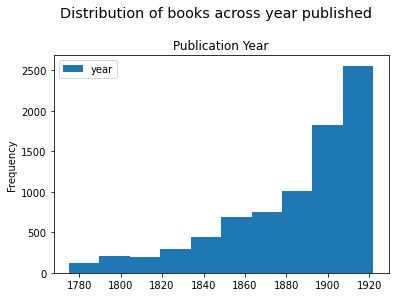

In [27]:
import matplotlib.pyplot as plt
# uncomment this statement to see the count for each year
# print(dfFull['year'].value_counts(ascending=True).sort_index())
print(f'Between 1775-1850 books: {round(len(dfFull.loc[dfFull.year<1875])/len(dfFull)*100)}%')
print(f'Between 1850-1900 books:{round(len(dfFull.loc[(dfFull.year>=1875) & (dfFull.year < 1900)])/len(dfFull)*100)}%')
print(f'Between 1900-1922 books: {round(len(dfFull.loc[(dfFull.year>=1900)& (dfFull.year <= 1922)])/len(dfFull)*100)}%')

dfFull.plot(kind='hist', title='Publication Year')
plt.suptitle('Distribution of books across year published', x=0.5, y=1.05, ha='center', fontsize='x-large')

To have a more even distribution of the dataset, as well as to have more manageable data points that the text of an entire book, I create 200 data points for each year represented in the set. The 200 points are 5000 character portions of the books attributed to that year. For years with only a few books, the points from that year will have less variety, perhaps yielding worse results than the years with a variety of different books. I do this before tokenizing and other processing the text as the process will be less intense once the texts have been truncated.

In [50]:
"""
Create new dataframe for final data. Each year will have 200 rows, each with a unique portion of text sourced
from a book published in that year
"""

all_years = []
PER_YEAR_COUNT = 200

for year in range(1775, 1923):
    years = [year]*PER_YEAR_COUNT
    all_years.extend(years)

print(len(all_years))
dfPas = pd.DataFrame(columns = ['title', 'passage', 'year'])
dfPas['year'] = all_years
dfPas['index'] = dfPas.index


pd.concat([dfPas.head(2), dfPas.tail(2)])

29600


,title,passage,year,index
0,NaN,NaN,1775,0
1,NaN,NaN,1775,1
29598,NaN,NaN,1922,29598
29599,NaN,NaN,1922,29599


In [51]:
import random
import copy
PASSAGE_LENGTH = 5000

dfFullCopy = dfFull.copy()
no_continue_list = []

def get_full_text(row):
    index = row['index']
    index_for_year = index % PER_YEAR_COUNT

    books_from_year = list(dfFullCopy[dfFullCopy.year == row['year']].index)

    # we have exhausted all the text from the books from this year. There are a few "bad" years with only 4 books
    if not len(books_from_year):
        print(f'THERE ARE NO BOOKS LEFT FOR {row.year}. NOT CONTINUING WITH THIS YEAR.')
        raise ValueError('Depleted books')
    
    index_in_book_list = index_for_year % len(books_from_year)
    book_index = books_from_year[index_in_book_list]
    
    book = dfFullCopy.loc[book_index]
    
    full_text = copy.copy(book['text'])

    return (full_text, book_index, book['title'])

def get_passage(row):
    if row['year'] in no_continue_list:
        return
    
    try:
        full_text, book_index, book_title = get_full_text(row)
    except ValueError:
        no_continue_list.append(row['year'])
        return
    
    # testing books are every 5th book for each year according to the original dataset
    # or if there are fewer than 5 books, the first book. 
    books_from_year_original = list(dfFull[dfFull.year == row['year']].index)
    testing_books = books_from_year_original[::5]
    row['test'] = book_index == 0 if len(books_from_year_original) < 5 else book_index in testing_books 
    
    # print(f'Creating excerpt for {row.year}: from {book_title}.')
    
    max_start_point = len(full_text) - PASSAGE_LENGTH
    start_point = random.randint(0, max_start_point)
    end_point = start_point+PASSAGE_LENGTH
    passage = full_text[start_point:end_point]
    
    if not len(passage) == PASSAGE_LENGTH:
        print(f'SOMETHING WENT WRONG FOR BOOK {book_title}')
        return
        
    # Remove the used text from the original dataframe if remaining text is less than the passage length, remove the book
    # Otherwise remove the used text from the existing full text and replace the modified text in the original df
    full_text_modified = full_text[:start_point] + full_text[end_point:]
    if len(full_text_modified) < PASSAGE_LENGTH:
        print(f'dropping book: {book_title} at index {book_index} from year {row.year}')
        dfFullCopy.drop([book_index], inplace=True)
    else:
        dfFullCopy.at[book_index,'text'] = full_text_modified
        new_text_length = len(dfFullCopy.loc[book_index]['text'])
    
        if not new_text_length < len(full_text):
            print(f'SOMETHING WENT WRONG FOR BOOK {book_title}')
            return
        
    row['passage'] = passage  
    row['title'] = book_title
    # print(f'Success! {len(row.passage)} char passage created for {book_title}.')

    return row


dfPas = dfPas.apply(get_passage, axis=1)
pd.concat([dfPas.head(2), dfPas.tail(2)])

total books  [333, 3964, 4287, 4295, 5196, 5880, 6398, 8326, 8496, 10381, 10433]
testing_books  [333, 5880, 10433]
book index  333
 is testing  True
total books  [333, 3964, 4287, 4295, 5196, 5880, 6398, 8326, 8496, 10381, 10433]
testing_books  [333, 5880, 10433]
book index  3964
 is testing  False
total books  [333, 3964, 4287, 4295, 5196, 5880, 6398, 8326, 8496, 10381, 10433]
testing_books  [333, 5880, 10433]
book index  4287
 is testing  False
total books  [333, 3964, 4287, 4295, 5196, 5880, 6398, 8326, 8496, 10381, 10433]
testing_books  [333, 5880, 10433]
book index  4295
 is testing  False
total books  [333, 3964, 4287, 4295, 5196, 5880, 6398, 8326, 8496, 10381, 10433]
testing_books  [333, 5880, 10433]
book index  5196
 is testing  False
total books  [333, 3964, 4287, 4295, 5196, 5880, 6398, 8326, 8496, 10381, 10433]
testing_books  [333, 5880, 10433]
book index  5880
 is testing  True
total books  [333, 3964, 4287, 4295, 5196, 5880, 6398, 8326, 8496, 10381, 10433]
testing_books  [

,title,passage,year,index,test
0,thomas jefferson,"led all the country with the exception of New England. Our commerce increased enormously, for the leading nations of Europe were warring with one another; money came in fast and most of the national debt was paid. Louisiana with an area exceeding all the rest of the United States, was bought from France in 1803, for $15,000,000, and from the territory were afterward carved the states of Louisiana, Arkansas, Missouri, Iowa, Kansas, Nebraska, the Dakotas, Montana, Oklahoma, the Indian Territory and most of the states of Wisconsin, Minnesota, Colorado and Wyoming. The upper Missouri River and the Columbia River country to the Pacific Ocean were explored in 1804-6, by Lewis and Clarke, the first party of white men to cross the continent north of Mexico. Ohio was admitted to the Union in 1802. Fulton's steamboat, the Clermont made her maiden trip from New York to Albany in 1807. The first boatload of anthracite coal was shipped to Philadelphia, and it was a long time before the people knew what to do with it. The Tripolitan Pirates were snuffed out (1801-1805). The blight of the Embargo Act settled upon our commerce in 1807, in which year the opening gun of the War of 1812 was fired when the Leopard outraged the Chesapeake. The Embargo Act was a grievous mistake of Jefferson, though its purpose was commendable. Under the plea of securing our ships against capture, its real object was to deprive England and France of the commodities which could be secured only in the Unite...",1775.0,0.0,True
1,charles lamb,"and anticipated that he would rival Milton. Then his taste was at all times peculiar. He seldom worshipped the Idol which the multitude had set up. I was never able to prevail on him to admit that ""Paradise Lost"" was greater than ""Paradise Regained;"" I believe, indeed, he liked the last the best. He would not discuss the Poetry of Lord Byron or Shelley, with a view of being convinced of their beauties. Apart from a few points like these, his opinions must be allowed to be sound; almost always; if not as to the style of the author, then as to the quality of his book or passage which he chose to select. And his own style was always good, from the beginning, in verse as well as in prose. His first sonnets are unaffected, well sustained, and well written. I do not know much of the opinion of others; but to my thinking the style of Charles Lamb, in his ""Elia,"" and in the letters written by him in the later (the last twenty) years of his life, is full of grace; not antiquated, but having a touch of antiquity. It is self-possessed, choice, delicate, penetrating, his words running into the innermost sense of things. It is not, indeed, adapted to the meanest capacity, but is racy, and chaste, after his fashion. Perhaps it is sometimes scriptural: at all events it is always earnest and sincere. He was painfully in earnest in his advocacy of Hazlitt and Hunt, and in his pleadings for Hogarth and the old dramatists. Even in his humor, his fictitious (as well as his real) personages...",1775.0,1.0,False
29598,the beautiful and damned,"ramme that'll take up every minute."" He did. He even figured to a nicety what would happen in the two hours when she would come to his apartment for tea: how the good Bounds would have the windows wide to let in the fresh breeze--but a fire going also lest there be chill in the air--and how there would be clusters of flowers about in big cool bowls that he would buy for the occasion. They would sit on the lounge. And when the day came they did sit upon the lounge. After a while Anthony kissed her because it came about quite naturally; he found sweetness sleeping still upon her lips, and felt that he had never been away. The fire was bright and the breeze sighing in through the curtains brought a mellow damp, promising May and world of summer. His soul thrilled to remote harmonies; he heard the strum of far guitars and waters lapping on a warm Mediterrane

All of the years are evenly distributed, except for three years that had very sparse data - less than four books each. 1781 only has 77 instances, 1791 only 87 instances, and 1784 has 166. This may yield less exact results for these years. In general, pre-1825 results will be worse than post-1825 as the amount of books available is relatively low for these years, meaning that there is less variety of examples of each year's text.

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

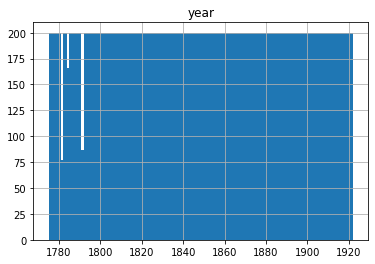

In [52]:
# histogram of datapoint distribution across years
dfPas.hist(column="year", bins=148)

In [53]:
"""
Delete rows without passages (from depleted years)
"""
print('Count before removal ',dfPas.shape[0])
dfPas = dfPas.drop(dfPas[dfPas.passage.apply(is_acceptable_length, length=(5000)) == False].index)
print('Count after removal ', dfPas.shape[0])


Count before removal  29600
Count after removal  29330


We have manually separate the training and testing data in the methods above rather than using a library. This is because we do not want to train the model to fit a specific book, but rather a specific year, therefor we must ensure that each book is either exclusively in the testing set or in the training set. The split comes to roughly 27% testing and 63% training

In [54]:
dfGrouped = dfPas.groupby(['test'])['test'].count().reset_index(
  name='Count').sort_values(['Count'], ascending=False)

print(dfGrouped.head())

# Validate that the testing and training label is consistent per book - insert any book title here
dfPas[dfPas['title']=='thomas jefferson']['test']

    test  Count
0  False  23084
1   True   6246


0      True
11     True
22     True
33     True
44     True
55     True
66     True
77     True
90     True
100    True
110    True
120    True
130    True
140    True
150    True
160    True
170    True
180    True
198    True
Name: test, dtype: object

Save data to testing and training csvs


In [55]:
dfTest = dfPas[dfPas['test']==True].drop(columns=['test', 'index'])
dfTrain = dfPas[dfPas['test']==False].drop(columns=['test', 'index'])
print('Training count: ', dfTrain.shape[0])
print('Testing count: ', dfTest.shape[0])

# dfTest.to_csv('testing.csv', index=False)
# dfTrain.to_csv('training.csv', index=False)

Training count:  23084
Testing count:  6246


In [108]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

MAX_WORDS = 10000

x_test = dfTest['passage']
y_test = dfTest['year']

x_train = dfTrain['passage']
y_train = dfTrain['year']

label_encoder = preprocessing.LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
y_train = label_encoder.fit_transform(y_train)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)


In [109]:
import numpy as np

MAX_LENGTH = 200

vocab_size = len(tokenizer.word_index)

x_train = pad_sequences(x_train, padding='post', maxlen=MAX_LENGTH)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_LENGTH)

embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()
print(f'Found {len(embeddings_dictionary)} word vectors')

Found 400001 word vectors


In [110]:
EMBEDDING_DIMENSION = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIMENSION))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [147]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


# FROM THE BOOK p190 - COULDN"T GET THIS TO WORK 

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIMENSION, weights=[embedding_matrix], input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_test, y_test))
model.save_weights('pre_trained_glove_model.h5')

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 200, 100)          42491700  
                                                                 
 flatten_14 (Flatten)        (None, 20000)             0         
                                                                 
 dense_55 (Dense)            (None, 32)                640032    
                                                                 
 dense_56 (Dense)            (None, 1)                 33        
                                                                 
Total params: 43,131,765
Trainable params: 640,065
Non-trainable params: 42,491,700
_________________________________________________________________
Epoch 1/10


ValueError: in user code:

    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/backend.py", line 5158, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 148)).


In [144]:
from keras.models import Model, Input

# DID THIS FROM HERE INSTEAD https://stackabuse.com/python-for-nlp-creating-multi-data-type-classification-models-with-keras/

input2 = Input(shape=(200,))
dense_layer_1 = Dense(10, activation='relu')(input2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(148, activation='softmax')(dense_layer_2)

model = Model(inputs=input2, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
145/145 [==============================] - 0s 1ms/step - loss: 18.3722 - acc: 0.0058 - val_loss: 1.4212 - val_acc: 0.0000e+00
Epoch 2/10
145/145 [==============================] - 0s 1ms/step - loss: 1.0145 - acc: 0.0085 - val_loss: 0.8253 - val_acc: 0.0000e+00
Epoch 3/10
145/145 [==============================] - 0s 999us/step - loss: 0.6939 - acc: 0.0085 - val_loss: 0.6429 - val_acc: 0.0000e+00
Epoch 4/10
145/145 [==============================] - 0s 1ms/step - loss: 0.5615 - acc: 0.0016 - val_loss: 0.5388 - val_acc: 0.0340
Epoch 5/10
145/145 [==============================] - 0s 1ms/step - loss: 0.4768 - acc: 0.0084 - val_loss: 0.4624 - val_acc: 0.0000e+00
Epoch 6/10
145/145 [==============================] - 0s 1ms/step - loss: 0.4139 - acc: 0.0084 - val_loss: 0.4041 - val_acc: 0.0000e+00
Epoch 7/10
145/145 [==============================] - 0s 1ms/step - loss: 0.3625 - acc: 0.0084 - val_loss: 0.3546 - val_acc: 0.0000e+00
Epoch 8/10
145/145 [=============================

In [141]:
score = model.evaluate(x_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])


ValueError: in user code:

    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1305, in test_step
        self.compiled_loss(
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/ronitronit/miniconda3/lib/python3.8/site-packages/keras/backend.py", line 5158, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 148) vs (None, 141)).


In [158]:
# """
# Methods for processing the excerpts
# """
# lemmatizer = WordNetLemmatizer()
# stop_words = list(stopwords.words('english'))

# # returns true if word should be filtered out (stop word, number, or length <= 2)
# def filter_word(word):
#     return word in stop_words or re.match('\d+', word) or len(word) <= 2

# delete_us = []
# def process_text(text):
#     # remove book intro text
#     text = text[100:]
#     text = text.lower()
#     text = word_tokenize(text)
#     text = [lemmatizer.lemmatize(word) for word in text]
#     text = [word for word in text if not filter_word(word)]
    
#     return text

# dfPasCopy = dfPas.copy()
# dfPasCopy['passage'] = dfPasCopy['passage'].apply(process_text)
# dfPasCopy.head()